In [1]:
import numpy as np
import pandas as pd 

import copy

np.random.seed(0) 
import random

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.utils import shuffle
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use("seaborn")

In [2]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('WARNING')
warnings.filterwarnings('ignore')

## Model with VGG-19 Arhcitecture on MNIST + Omniglot datasets
--------------------

### Ідея
Метою даної роботи є модернізація CNN з VGG-19 архітектурою шляхом впровадженя в неї EE-блоку та дослідження характеристик побудованої нейронної мережі на задачах класифікації зображень, а також порівняння результатів даної мережі з моделлю, яка реалізує VGG-19 архітектуру, але без використання Early-Exit блоку.

### Моодель
У цьому ноутбуці продемонстровано результати виконання моделі на основі VGG-19 архітектури для їхнього порівняння з результатами розробленої моделі з впровадженим Early-Exit блоком.

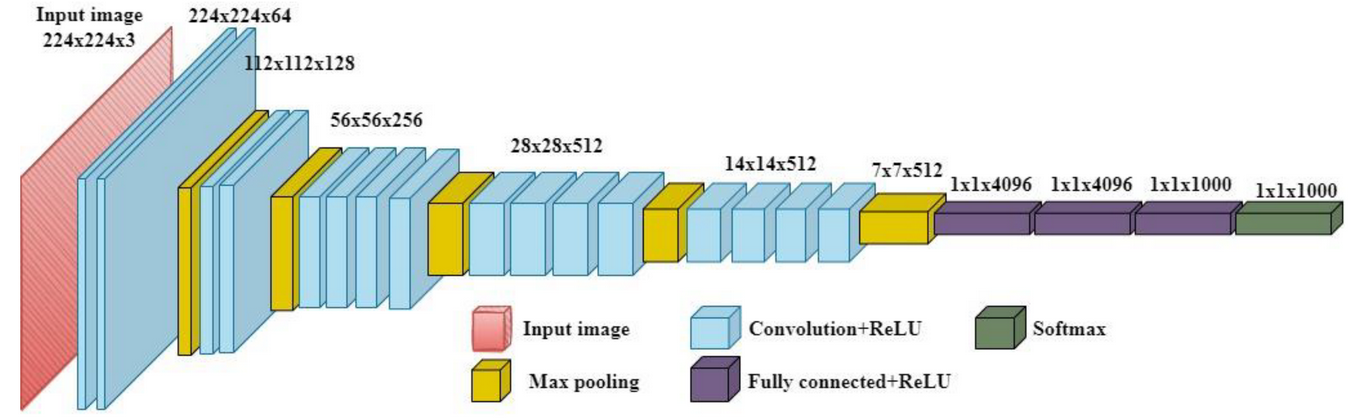
### *Рис.1: Модель на основі VGG-19 архітектури.*

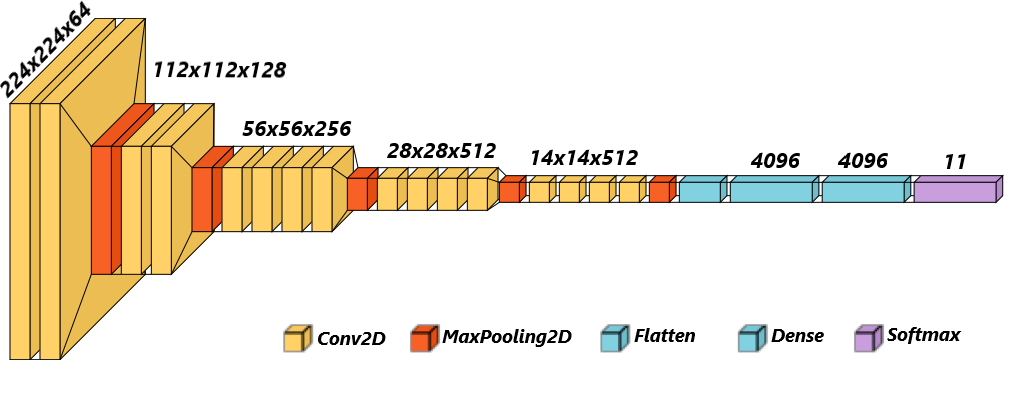
### *Рис.2: Модель на основі VGG-19 архітектури, використана у поданій роботі.*

## Loading and Preprocessing Omniglot dataset

Набір даних Omniglot містить зображення 1623 символів з 50 різних алфавітів. Таким чином датасет містить 32460 зображень, з яких 19280 відведені для тренувального кроку (у поданій роботі розглядалось 15424 для тренування та 3856 для валідації) та 13180 для тестування моделі. Цей набір даних було створено для вивчення проблеми навчання з першого разу (one-shot learning), тобто вивчення завдання лише на одному прикладі. Кожне зображення подане з розміром 105х105 пікселів у форматі RGB. Оскільки зображення з набору даних Omniglot будуть слугувати як надлишкові дані, у поданій роботі значення їх цілей передбачення (1623 класи символів) будуть змінені на 1 клас, який буде позначати всі зображення з цього датасету. Також зображення розглядаються у форматі 64х64 пікселі.

Зображення з Omniglot датасету подані у форматі RGB, тому для ефективного об’єднання цього набору даних з MNIST зображення з Omniglot потрібно перевести у формат градації сірого. Також ці зображення необхідно нормалізувати та значення пікселів інверсувати для асиміляції цих зображень з MNIST датасетом.

In [3]:
# Load omniglot dataset 
(train_val_omniglot_ds, test_omniglot_ds), omniglot_ds_info = tfds.load(
    'omniglot', 
    split=['train', 'test'], 
    as_supervised=True, 
    shuffle_files=True, 
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling omniglot-train.tfrecord...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling omniglot-test.tfrecord...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling omniglot-small1.tfrecord...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling omniglot-small2.tfrecord...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Dataset omniglot downloaded and prepared to /root/tensorflow_datasets/omniglot/3.0.0. Subsequent calls will reuse this data.


In [4]:
print('Number of images')
print(f"Training + validation omniglot dataset: {len(train_val_omniglot_ds)}")
print(f"Test omniglot dataset: {len(test_omniglot_ds)}")
print(f"Total: {len(train_val_omniglot_ds) + len(test_omniglot_ds)}")

Number of images
Training + validation omniglot dataset: 19280
Test omniglot dataset: 13180
Total: 32460


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


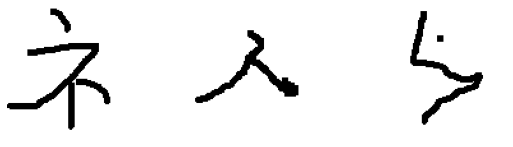

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


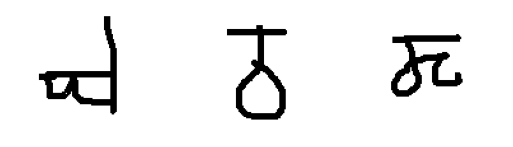

In [5]:
fig = tfds.show_examples(train_val_omniglot_ds.take(3), omniglot_ds_info)
fig = tfds.show_examples(test_omniglot_ds.take(3), omniglot_ds_info)

In [6]:
def convert_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = 1.0 - image
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize_with_pad(
        image=image,
        target_height=img_height, 
        target_width=img_width,
        method='nearest',
    )
    label = 10                  # 'non digit' class
    return image, label

In [7]:
img_height = 64
img_width = 64

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_val_converted_omniglot_ds = (
    train_val_omniglot_ds
    .map(convert_images)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
test_converted_omniglot_ds = (
    test_omniglot_ds
    .map(convert_images)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

y_omniglot = np.asarray([y for X, y in train_val_converted_omniglot_ds])
X_omniglot = np.asarray([X for X, y in train_val_converted_omniglot_ds])
y_omniglot_test = np.asarray([y for X, y in test_converted_omniglot_ds])
X_omniglot_test = np.asarray([X for X, y in test_converted_omniglot_ds])

clear_output()

In [8]:
print('Omniglot dataset (transformed)')
print(f'Train: X={X_omniglot.shape}, y={y_omniglot.shape}')
print(f'Test: X={X_omniglot_test.shape}, y={y_omniglot_test.shape}')

Omniglot dataset (transformed)
Train: X=(19280, 64, 64, 1), y=(19280,)
Test: X=(13180, 64, 64, 1), y=(13180,)


In [9]:
len(np.unique(y_omniglot))

1

In [10]:
X_omniglot[0].min(), X_omniglot[0].max()

(0.0, 0.99990004)

In [11]:
def plot_digit(image, value, plt, i):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.title(f"Value: {value}")
    plt.xticks([])
    plt.yticks([])

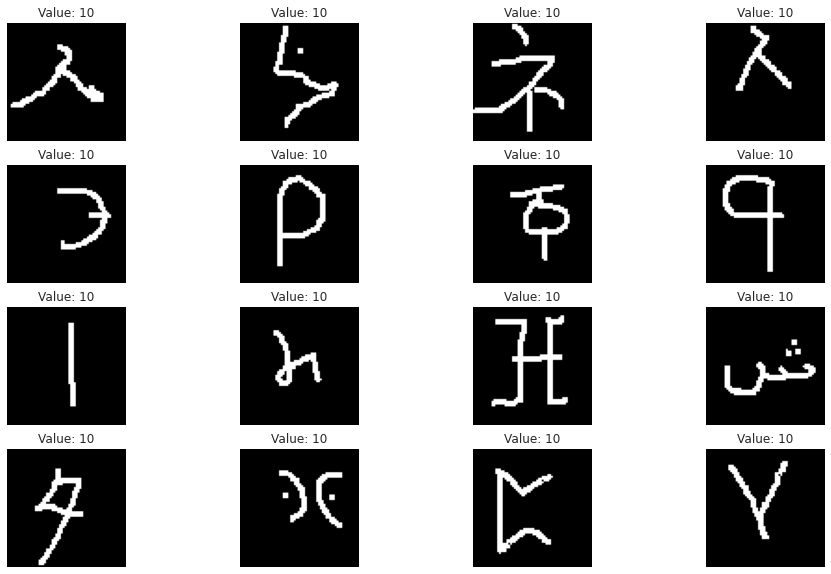

In [12]:
# Converted omniglot dataset
plt.figure(figsize=(16, 10))
for i in range(16):
    plot_digit(X_omniglot[i], y_omniglot[i], plt, i)
    
plt.show()

## Loading and Preprocessing MNIST dataset

У наборі даних MNIST є загалом 70000 фотографій вручну написаних цифр розміром 28x28 пікселів, з яких 60000 відведені для тренувального кроку (у поданій роботі розглядалось 48000 для тренування та 12000 для валідації) та 10000 для тестування моделі. Як ціль передбачення (prediction target) для кожного зображення використовується цифра, зображена на ньому. Таким чином MNIST датасет містить загалом 10 різних класів. Розмірність вектора, який визначає формат кольору зображень, в даному датасеті рівна 1. Тобто зображення представлені у форматі градації сірого (grayscale). Для проведення подальших досліджень всі зображення були були переведені у формат 64х64 пікселів з нормалізацією значення самих зображень. Набір даних MNIST використовується в опрацюванні першої експериментальної моделі разом з Omniglot датасетом.

In [13]:
(X_mnist, y_mnist), (X_mnist_test, y_mnist_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [14]:
print(X_mnist.shape)

(60000, 28, 28)


In [15]:
print('MNIST dataset (original)')
print(f'Train: X={X_mnist.shape}, y={y_mnist.shape}')
print(f'Test: X={X_mnist_test.shape}, y={y_mnist_test.shape}')

MNIST dataset (original)
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [16]:
X_mnist = X_mnist.reshape((X_mnist.shape + (1,)))
X_mnist_test = X_mnist_test.reshape((X_mnist_test.shape + (1,)))

print(f'X: train={X_mnist.shape}, test={X_mnist_test.shape}')

X: train=(60000, 28, 28, 1), test=(10000, 28, 28, 1)


In [17]:
X_mnist = X_mnist.astype('float32')
X_mnist_test = X_mnist_test.astype('float32')

X_mnist = X_mnist / 255
X_mnist_test = X_mnist_test / 255

X_mnist[0].min(), X_mnist[0].max()

(0.0, 1.0)

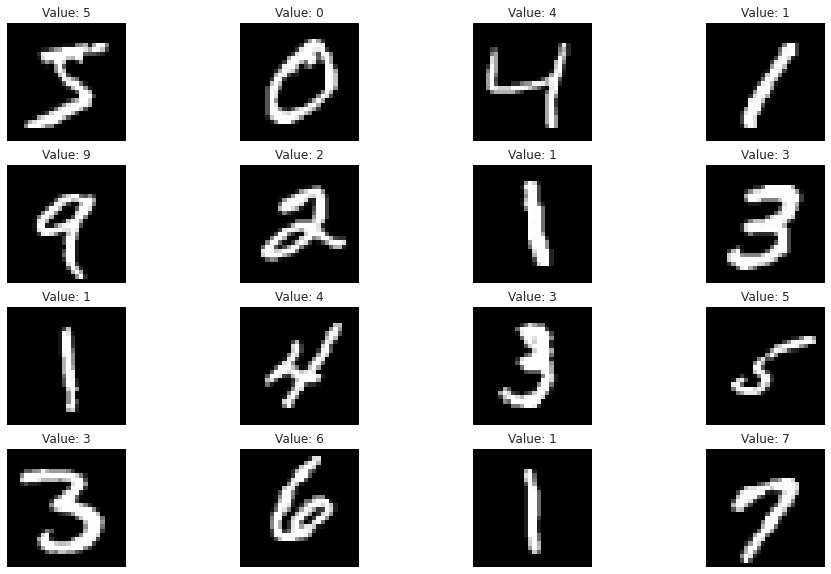

In [18]:
# Before resizing (with defualt size 28x28)
plt.figure(figsize=(16, 10))
for i in range(16):
    plot_digit(X_mnist[i], y_mnist[i], plt, i)
    
plt.show()

In [19]:
# Resizing images from 28x28 to 64x64 (returns EagerTensor type)
X_mnist = tf.image.resize_with_pad(
    image=X_mnist,
    target_height=img_height, 
    target_width=img_width,
    method='nearest',
)
X_mnist_test = tf.image.resize_with_pad(
    image=X_mnist_test,
    target_height=img_height, 
    target_width=img_width,
    method='nearest',
)

# Convert EagerTensor to numpy array
X_mnist = X_mnist.numpy()
X_mnist_test = X_mnist_test.numpy()

In [20]:
print('MNIST dataset (transformed)')
print(f'Train: X={X_mnist.shape}, y={y_mnist.shape}')
print(f'Test: X={X_mnist_test.shape}, y={y_mnist_test.shape}')

MNIST dataset (transformed)
Train: X=(60000, 64, 64, 1), y=(60000,)
Test: X=(10000, 64, 64, 1), y=(10000,)


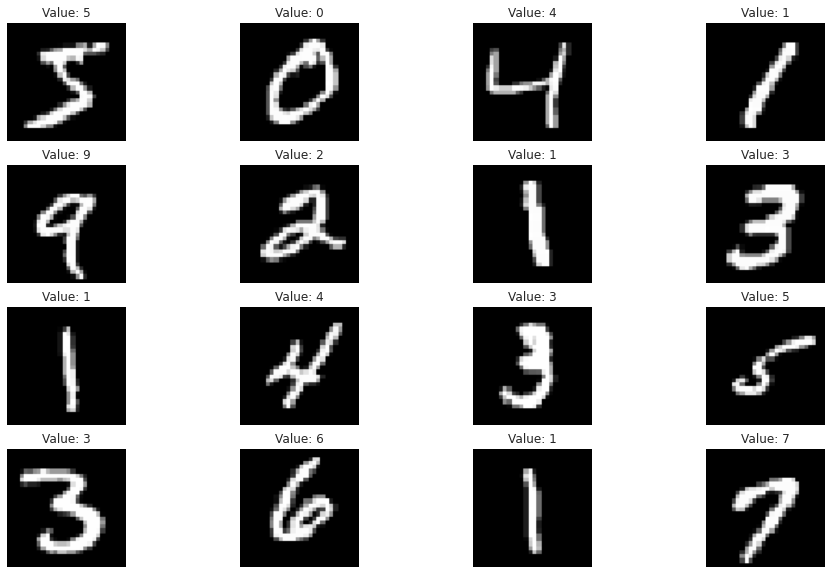

In [21]:
# After resizing (with size 64x64)
plt.figure(figsize=(16, 10))
for i in range(16):
    plot_digit(X_mnist[i], y_mnist[i], plt, i)
    
plt.show()

In [22]:
num_of_classes = len(np.unique(y_mnist))
num_of_classes

10

In [23]:
input_shape_mnist = X_mnist.shape[1:]
input_shape_mnist

(64, 64, 1)

### Function to define model with VGG-19 Architecture
---

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

def get_vgg19_model():
    return keras.Sequential([
        # Convolutional base for feature extraction 
        # Block One
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape_mnist),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Two
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Three
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Four
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Block Five
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid'),

        # Head of dense (fully connected) layers for classification
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(num_of_classes, activation='softmax'),
    ])

In [25]:
early_stopping = EarlyStopping(
    min_delta=0.01, 
    patience=3, 
    restore_best_weights=True,
)

## Concatenation of MNIST and Omniglot datasets
---

In [26]:
X = np.concatenate((X_mnist, X_omniglot), axis=0)
y = np.concatenate((y_mnist, y_omniglot), axis=0)

X_test = np.concatenate((X_mnist_test, X_omniglot_test), axis=0)
y_test = np.concatenate((y_mnist_test, y_omniglot_test), axis=0)

# Shuffle concatenated validation and testing features and targets simultaneously
X, y = shuffle(X, y)
X_test, y_test = shuffle(X_test, y_test)

In [27]:
print(f'Train: X={X.shape}, y={y.shape}')
print(f'Test: X={X_test.shape}, y={y_test.shape}')

Train: X=(79280, 64, 64, 1), y=(79280,)
Test: X=(23180, 64, 64, 1), y=(23180,)


## Building a model
---

In [28]:
num_of_classes = len(np.unique(y))
num_of_classes

11

Оскільки дані у prediction target подані як цілі числа [0, 10], які репрезентують відповідні цифри на фотографіях (classification), є два шляхи опрацювання та побудови моделі. З одного боку, можна залишити все як є та вважати, що ми працюємо з виконаним ordinal encoding. З іншого боку, можна використати onehot encoding, з допомогою якого буде створено 10 нових стовпців, кожен з яких буде представляти цифру. Таким чином кожна фотографія буде мітисти 10-елементний вектор, кожне значення якого буде вказувати яку цифру представляє фотографія. 

In [29]:
y = to_categorical(y)
y_test = to_categorical(y_test)

print(f'y_one_hot: train={y.shape}')

y_one_hot: train=(79280, 11)


In [30]:
input_shape_mnist = X.shape[1:]
input_shape_mnist

(64, 64, 1)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [32]:
vgg_19_model_onehot = get_vgg19_model()

In [33]:
vgg_19_model_onehot.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
vgg_19_model_onehot.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [34]:
early_stopping = EarlyStopping(
    min_delta=0.01, 
    patience=3, 
    restore_best_weights=True,
)

In [35]:
history_vgg19_onehot_omniglot_and_mnist = vgg_19_model_onehot.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=5,
    callbacks=[early_stopping],
)

Epoch 1/5
991/991 [==============================] - 118s 102ms/step - loss: 2.1262 - accuracy: 0.2853 - val_loss: 0.6329 - val_accuracy: 0.7818
Epoch 2/5
991/991 [==============================] - 103s 104ms/step - loss: 0.2146 - accuracy: 0.9317 - val_loss: 0.1190 - val_accuracy: 0.9663
Epoch 3/5
991/991 [==============================] - 103s 104ms/step - loss: 0.0703 - accuracy: 0.9781 - val_loss: 0.0650 - val_accuracy: 0.9801
Epoch 4/5
991/991 [==============================] - 103s 104ms/step - loss: 0.0441 - accuracy: 0.9868 - val_loss: 0.0415 - val_accuracy: 0.9882
Epoch 5/5
991/991 [==============================] - 103s 104ms/step - loss: 0.0368 - accuracy: 0.9889 - val_loss: 0.0351 - val_accuracy: 0.9899


In [36]:
score_onehot_omniglot_and_mnist = vgg_19_model_onehot.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_onehot_omniglot_and_mnist[0])
print('Test score:', score_onehot_omniglot_and_mnist[1])

print("CNN Error: %.2f%%" % (100-score_onehot_omniglot_and_mnist[1]*100))

Test loss: 0.01928592659533024
Test score: 0.994305431842804
CNN Error: 0.57%


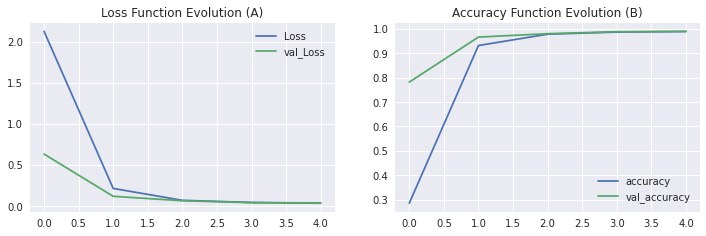

In [37]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_vgg19_onehot_omniglot_and_mnist.history['loss'], label='Loss')
plt.plot(history_vgg19_onehot_omniglot_and_mnist.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution (A)')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_vgg19_onehot_omniglot_and_mnist.history['accuracy'], label='accuracy')
plt.plot(history_vgg19_onehot_omniglot_and_mnist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution (B)')
plt.legend()

## Prediction and Confusion Matrix

In [38]:
# GPU T4 x2, batch_size = 32 (default)
import time

start_time = time.time()
#Predict y_test values for comparison in confusion matrix (omniglot + mnist, 11 classes)
y_test_pred_omniglot_and_mnist = vgg_19_model_onehot.predict(X_test)
elapsed = time.time() - start_time

y_test_true_omniglot_and_mnist = y_test

print(f"Inference time for all samples: {np.round(elapsed, 6)} sec.\nAverage inference time for 1 sample (omniglot + mnist dataset, 11 classes): {np.round(elapsed / len(X_test), 6)} sec.")

Inference time for all samples: 21.645633 sec.
Average inference time for 1 sample (omniglot + mnist dataset, 11 classes): 0.000934 sec.


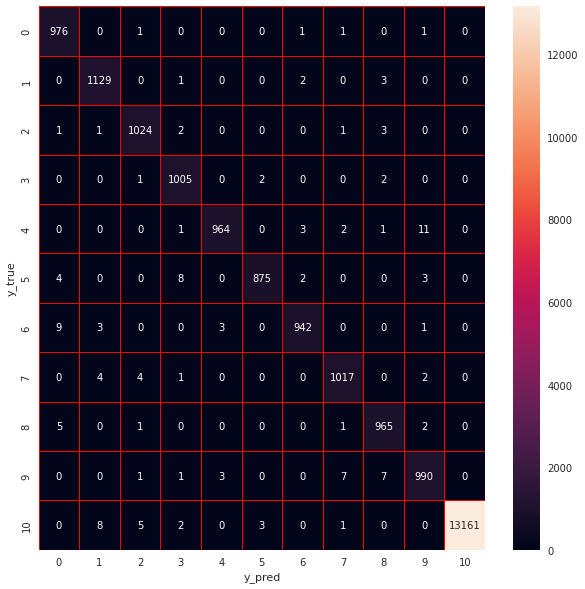

In [39]:
#Confusion matrix for mnist + omniglot evaluation data
omniglot_mnist_cm=confusion_matrix(y_test_true_omniglot_and_mnist.argmax(axis=1), y_test_pred_omniglot_and_mnist.argmax(axis=1))

f, ax=plt.subplots(figsize=(10,10))
sns.heatmap(omniglot_mnist_cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [40]:
# 10 stands for char
print(classification_report(y_test_true_omniglot_and_mnist.argmax(axis=1), y_test_pred_omniglot_and_mnist.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.98      0.98      0.98      1009
          10       1.00      1.00      1.00     13180

    accuracy                           0.99     23180
   macro avg       0.99      0.99      0.99     23180
weighted avg       0.99      0.99      0.99     23180



### Other results representation
---

In [41]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "char"]
def plot_image(i, predictions_array, true_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.gray)

    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_array):
    plt.grid(False)
    plt.xticks(range(11))
    plt.yticks([])
    thisplot = plt.bar(range(11), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    true_label = np.argmax(true_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

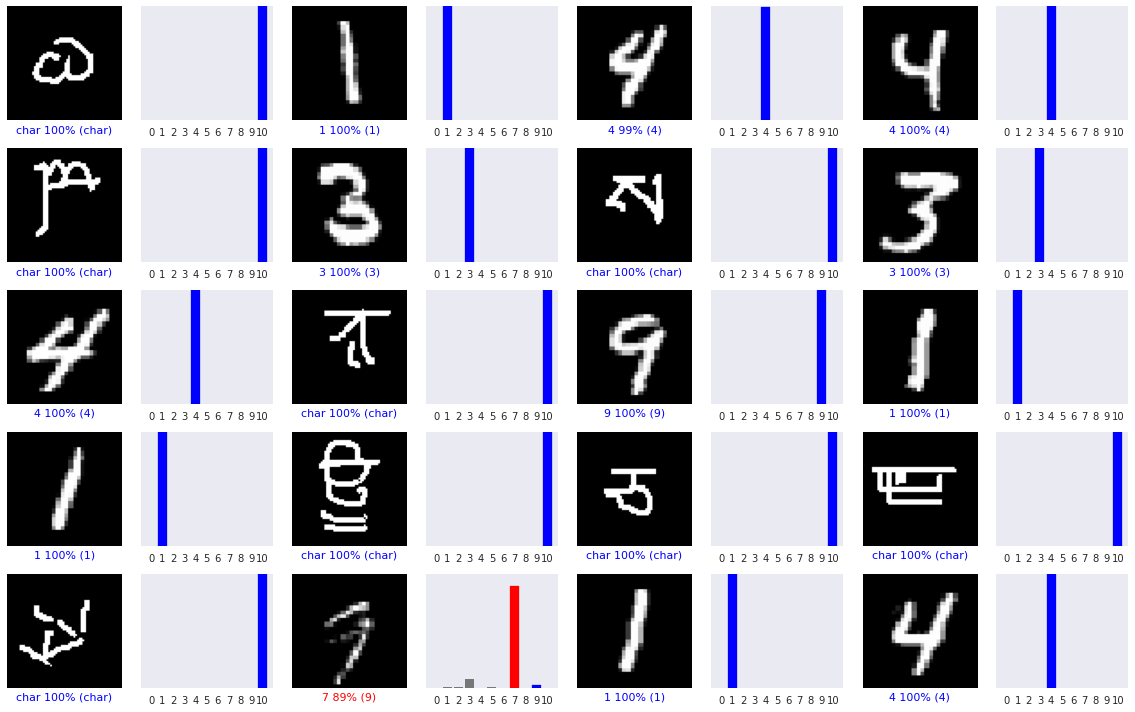

In [42]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, y_test_pred_omniglot_and_mnist[i+20], y_test_true_omniglot_and_mnist[i+20], X_test[i+20])
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_test_pred_omniglot_and_mnist[i+20], y_test_true_omniglot_and_mnist[i+20])
plt.tight_layout()
plt.show()